In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import joblib

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [49]:
df = pd.read_csv("../data/DSNY_Monthly_Tonnage_Data.csv")
# changing month to datetime for pandas
df['MONTH'] = pd.to_datetime(df['MONTH'])
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24647 entries, 0 to 24646
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   MONTH                24647 non-null  datetime64[ns]
 1   BOROUGH              24647 non-null  object        
 2   COMMUNITYDISTRICT    24647 non-null  int64         
 3   REFUSETONSCOLLECTED  24647 non-null  float64       
 4   PAPERTONSCOLLECTED   22213 non-null  float64       
 5   MGPTONSCOLLECTED     22570 non-null  float64       
 6   RESORGANICSTONS      3095 non-null   float64       
 7   SCHOOLORGANICTONS    2308 non-null   float64       
 8   LEAVESORGANICTONS    881 non-null    object        
 9   XMASTREETONS         1685 non-null   float64       
 10  OTHERORGANICSTONS    1933 non-null   float64       
 11  BOROUGH_ID           24647 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 2.3+ MB


/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_16064/2461424894.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['MONTH'] = pd.to_datetime(df['MONTH'])


,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,OTHERORGANICSTONS,BOROUGH_ID
0,2025-10-01,Bronx,1,3352.0,235.0,124.8,16.7,85.9,NaN,NaN,NaN,2
1,2025-10-01,Bronx,2,7942.4,231.6,213.8,20.4,100.7,NaN,NaN,NaN,2
2,2025-10-01,Bronx,3,2348.6,140.1,147.5,19.1,NaN,NaN,NaN,NaN,2
3,2025-10-01,Bronx,4,4210.4,233.3,291.1,20.8,70.7,NaN,NaN,0.3,2
4,2025-10-01,Bronx,5,3578.3,216.6,299.9,17.1,85.6,NaN,NaN,NaN,2


In [50]:
newdata = df[(df['MONTH'] >= '2022-01-01')]

recycles = newdata['PAPERTONSCOLLECTED'] + newdata['MGPTONSCOLLECTED']
total = newdata['PAPERTONSCOLLECTED'] + newdata['MGPTONSCOLLECTED'] + newdata['REFUSETONSCOLLECTED']

newdata['proportionrefuse'] = recycles / total

# creating identifier
newdata['id'] = newdata['BOROUGH'] + newdata['COMMUNITYDISTRICT'].astype(str)

# data for model
modeldata = newdata[['MONTH','id','proportionrefuse','REFUSETONSCOLLECTED','PAPERTONSCOLLECTED','MGPTONSCOLLECTED']]

#cleaning id
modeldata['id'] = modeldata['id'].str.lower().str.strip()
modeldata['id'] = modeldata['id'].str.replace(' ','')
modeldata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2714 entries, 0 to 2713
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   MONTH                2714 non-null   datetime64[ns]
 1   id                   2714 non-null   object        
 2   proportionrefuse     2714 non-null   float64       
 3   REFUSETONSCOLLECTED  2714 non-null   float64       
 4   PAPERTONSCOLLECTED   2714 non-null   float64       
 5   MGPTONSCOLLECTED     2714 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 148.4+ KB


/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_16064/1286007878.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata['proportionrefuse'] = recycles / total
/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_16064/1286007878.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata['id'] = newdata['BOROUGH'] + newdata['COMMUNITYDISTRICT'].astype(str)
/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_16064/1286007878.py:15: SettingWithCopyWarning: 
A value is trying to be

In [51]:
# user input to filter our timeseries for a

attempts = 0
max_attempts = 100000
listofunique = []

for i in range(len(modeldata['id'].unique())):
    listofunique.append(modeldata['id'].iloc[i])

#list of each unique identifier in data
listofunique

while attempts < max_attempts:
    user_input = input("Enter a borough and district (FORMAT: bronx1): ")
    user_input = user_input.lower().strip()
    user_input = user_input.replace(' ','')
    if user_input in listofunique:
        break
    else:
        raise ValueError("Not a valid district")
        attempts += 1

if attempts == max_attempts:
    raise ValueError("Too many invalid attempts")

In [52]:
# filter df and creating data for timeseries (s)

filtered = modeldata[modeldata['id'] == user_input]
filtered = filtered[(filtered['MONTH'] >= '2023') & (filtered['MONTH'] < '2025')]

s = filtered.set_index(filtered['MONTH'])['proportionrefuse'].asfreq('MS')


In [53]:
# train test splits
split_idx = int(len(s) * 0.70)
# all of 2023
train = s.iloc[:split_idx]
# all of 2024
test  = s.iloc[split_idx:]

In [54]:
# --- Fit SARIMA(p, d, q)(P, D, Q)s ---
model = SARIMAX(
    train,
    order=(1, 1, 1),        # ARIMA part: p, d, q
    seasonal_order=(1, 1, 1, 12),   # Seasonal: P, D, Q, s (e.g., 12 months)
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


queens2 Sarima (1,1,1,12) RMSE: 0.005


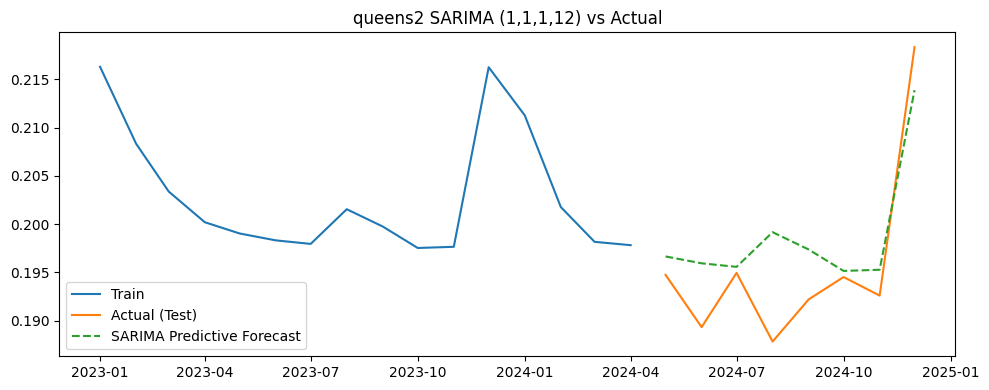

In [55]:
predictions = results.forecast(steps=len(test))
sarima_rmse = np.sqrt(mean_squared_error(test, predictions))

print(f"{user_input} Sarima (1,1,1,12) RMSE: {sarima_rmse:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="#ff7f0e")
plt.plot(predictions, label="SARIMA Predictive Forecast", color="#2ca02c", linestyle="--")
plt.title(f"{user_input} SARIMA (1,1,1,12) vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

# queens6 good to show possible estimates
# queens2
# manhattan 3

In [56]:
# PICKLE CODE (avoids having data preset to a specific borough/district combo)

# Load CSV and preprocess
df = pd.read_csv("../data/DSNY_Monthly_Tonnage_Data.csv")
df['MONTH'] = pd.to_datetime(df['MONTH'])
df = df[(df['MONTH'] >= '2023') & (df['MONTH'] < '2025')]
df['id'] = (df['BOROUGH'] + df['COMMUNITYDISTRICT'].astype(str)).str.lower().str.replace(' ','')
df['proportionrefuse'] = (df['PAPERTONSCOLLECTED'] + df['MGPTONSCOLLECTED']) / (
    df['PAPERTONSCOLLECTED'] + df['MGPTONSCOLLECTED'] + df['REFUSETONSCOLLECTED']
)

# Fit SARIMA models per ID using train split
sarima_models = {}

for user_id in df['id'].unique():
    series = df[df['id'] == user_id].set_index('MONTH')['proportionrefuse'].asfreq('MS')

    # Train/test split
    split_idx = int(len(series) * 0.70)
    train = series.iloc[:split_idx]

    # Fit SARIMA only on train
    model = SARIMAX(
    train,
    order=(1, 1, 1),        # ARIMA part: p, d, q
    seasonal_order=(1, 1, 1, 12),   # Seasonal: P, D, Q, s (e.g., 12 months)
    enforce_stationarity=False,
    ).fit(low_memory=True)
    
    sarima_models[user_id] = model

# Pickle the dictionary
with open("../models/modeling_tuned.pkl", "wb") as f:
    joblib.dump(sarima_models, f)

/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_16064/1484625903.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['MONTH'] = pd.to_datetime(df['MONTH'])
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
